In [1]:
#Run this cell for markdown formatting assistance. This is not a part of the assignment.

from IPython.core.display import HTML
table_css = 'table {align:left;display:block} '
HTML('<style>{}</style>'.format(table_css))

# MGTA 466: Analytics Assignment 3 - EDA on Airline Data

#### Submission on Gradescope:
  * You need to submit the following two files under "PA3". Instructions to generate the csv files are given in their respective sections
      * The current notebook - **PA3_Starter.ipynb** - with all cells executed
      * csv file containing the top 50 rows of the input dataframe with transformed columns 'MONTH' and 'DAY_OF_WEEK' and filtered such that only flights from the smallest flight carrier are present + column header - **50_rows.csv**
      
#### IMPORTANT submission guidelines enforced by autograder. Please read carefully:
  * Make sure that all the cells in this notebook are executed and that the outputs are present in the expected cells before submission
  * Some cells are marked **DO NOT DELETE**. These cells cannot be deleted and the output of these cells will be used for autograding
  * You can add additional cells, but the **Expected Output** for each of the tasks MUST be the output of the cells marked as such
  * DO NOT print anything other than the *exact* expected output. **Do not include any sentences/words describing the output**. This is strictly enforced by the autograder which checks for an *exact* match of the expected output. For example, if you are expected to print the PySpark version:
      * '10.9.8' - <span style="color:#093">CORRECT</span>
      * 'The PySpark version is 10.9.8' - <span style="color:#FF0000">INCORRECT</span>
  * You can add cells for printing debugging information anywhere, but do not print anything else in **Expected Output** cells other than the expected output for the task
---

Remember: when in doubt, read the documentation first. It's always helpful to search for the class that you're trying to work with, e.g. pyspark.sql.DataFrame. 

PySpark API Documentation: https://spark.apache.org/docs/latest/api/python/index.html

Spark DataFrame Guide:  https://spark.apache.org/docs/latest/sql-programming-guide.html

### General instructions for all plots (Important for Autograder)
1. All plots must have the given title and axes labels
2. Figure size (figsize) for all plots must be set to (10,8)
3. Keep the color of the plots and other style attributes set to default
4. Always do plt.show() at the end to display the plots

In [2]:
import matplotlib.pyplot as plt
import matplotlib

### 1. Start Spark Session

#### **Expected output**: None

In [3]:
# Suppress native-hadoop warning
!sed -i '$a\# Add the line for suppressing the NativeCodeLoader warning \nlog4j.logger.org.apache.hadoop.util.NativeCodeLoader=ERROR,console' /$HADOOP_HOME/etc/hadoop/log4j.properties

In [4]:
# Change the number of cores in this code block
# by setting `spark.master` to `local[n]` where
# n is the number of cores
import pyspark
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAll([('spark.master', 'local[4]'),
                                   ('spark.app.name', 'Spark Demo')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()
pyspark.__version__

'3.5.1'

### 2. Set Schema & Load Data - 1 point

Define schema for the data file with the following columns for the corresponding data types and other rules:
- Integer: '_c0', 'OP_CARRIER_FL_NUM'
- String: 'FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DEST', 'CANCELLATION_CODE'
- Double: 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY', 'CANCELLED', 'DIVERTED', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'

- Many time related columns are set to be double cause they need further processing before they can be converted to datetime
- All columns can have NULL values
- Useful links: [pyspark.sql.types.StructField](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.types.StructField.html), [pyspark.sql.types.StructType](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.types.StructType.html), [DataTypes](https://spark.apache.org/docs/latest/sql-ref-datatypes.html)

Read data from the `Airline_2016_2018.csv` file using the defined schema and select only 'FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DISTANCE', 'CANCELLED', 'ARR_DELAY' fields
Note: The given csv file is zipped and it needs to be unzipped before it can be loaded
#### **Expected output**: Schema of the dataframe after selecting 'FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DISTANCE', 'CANCELLED', 'ARR_DELAY' fields

In [5]:
!pwd

/home/jovyan/MGTA466:Session1/Demo1-Local


In [6]:
file_path = "file:///home/jovyan/MGTA466:Session1/Demo1-Local/Airline_2016_2018.csv"

df = spark.read.csv(file_path, header=True, inferSchema=True).cache()

In [7]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nulla

In [8]:
from pyspark.sql.functions import col

df_selected = df.select("FL_DATE", "OP_CARRIER", "ORIGIN", "DISTANCE", "CANCELLED", "ARR_DELAY")

df_transformed = df_selected \
    .withColumn("FL_DATE", col("FL_DATE").cast("string")) \
    .withColumn("DISTANCE", col("DISTANCE").cast("double")) \
    .withColumn("CANCELLED", col("CANCELLED").cast("double")) \
    .withColumn("ARR_DELAY", col("ARR_DELAY").cast("double"))

In [9]:
df_transformed.printSchema()

root
 |-- FL_DATE: string (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)



### 3. Clean the data - 1 point

##### Task:
1. Remove all cancelled flights and remove rows with any empty values.
2. Drop the 'CANCELLED' column from the Dataframe after filtering.

Note: 'CANCELLED' = 0 shows that the flight is not cancelled

##### Expected output:
The first 25 rows of the cleaned dataframe

In [10]:
df_transformed.show(5)

+----------+----------+------+--------+---------+---------+
|   FL_DATE|OP_CARRIER|ORIGIN|DISTANCE|CANCELLED|ARR_DELAY|
+----------+----------+------+--------+---------+---------+
|2016-01-01|        DL|   DTW|  1979.0|      0.0|    -24.0|
|2016-01-01|        DL|   ATL|   640.0|      0.0|     -2.0|
|2016-01-01|        DL|   LAX|  1947.0|      0.0|    -13.0|
|2016-01-01|        DL|   SLC|  1590.0|      0.0|    -16.0|
|2016-01-01|        DL|   BZN|   874.0|      0.0|    124.0|
+----------+----------+------+--------+---------+---------+
only showing top 5 rows



In [11]:
df_cleaned = df_transformed.filter(col("CANCELLED") == 0).dropna().drop("CANCELLED")

In [12]:
df_cleaned.show(25)

+----------+----------+------+--------+---------+
|   FL_DATE|OP_CARRIER|ORIGIN|DISTANCE|ARR_DELAY|
+----------+----------+------+--------+---------+
|2016-01-01|        DL|   DTW|  1979.0|    -24.0|
|2016-01-01|        DL|   ATL|   640.0|     -2.0|
|2016-01-01|        DL|   LAX|  1947.0|    -13.0|
|2016-01-01|        DL|   SLC|  1590.0|    -16.0|
|2016-01-01|        DL|   BZN|   874.0|    124.0|
|2016-01-01|        DL|   ATL|   214.0|     83.0|
|2016-01-01|        DL|   BNA|   214.0|     74.0|
|2016-01-01|        DL|   ATL|   270.0|      3.0|
|2016-01-01|        DL|   JAX|   270.0|    -15.0|
|2016-01-01|        DL|   ATL|   761.0|    -12.0|
|2016-01-01|        DL|   MSP|  1517.0|    -33.0|
|2016-01-01|        DL|   LAX|  2475.0|    -14.0|
|2016-01-01|        DL|   ATL|   620.0|    -11.0|
|2016-01-01|        DL|   MDT|   620.0|    -15.0|
|2016-01-01|        DL|   SLC|  1990.0|      6.0|
|2016-01-01|        DL|   SAV|   214.0|    -18.0|
|2016-01-01|        DL|   BUF|   712.0|      6.0|


### 4. Date/time transformations - 1 point

##### Tasks
1. Get the day of week (ranging from 1 for a Sunday to a 7 for Saturday) for each row and store it in a column named 'DAY_OF_WEEK'
2. Get the month for each row from the column FL_DATE, cast it to [ShortType](https://spark.apache.org/docs/latest/sql-ref-datatypes.html) and store it in column 'MONTH'

Note: The column 'FL_DATE' has date in YYYY-MM-DD format

Useful functions - [pyspark.sql.functions.dayofweek](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.dayofweek.html), [pyspark.sql.functions.split](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.split.html), [pyspark.sql.Column.cast](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.cast.html)

##### **Expected output** -  The top 25 rows of the transformed dataframe with columns 'FL_DATE', 'OP_CARRIER', 'ORIGIN', 'DISTANCE', 'ARR_DELAY', 'DAY_OF_WEEK', 'MONTH'
Your output should look like this:

|   FL_DATE|OP_CARRIER|ORIGIN|DISTANCE|ARR_DELAY|DAY_OF_WEEK|MONTH|
| ---------|----------|------|--------|---------|-----------|-----|
|2016-01-01|        DL|   DTW|  1979.0|    -24.0|          6|    1|
|2016-01-01|        DL|   ATL|   640.0|     -2.0|          6|    1|

..23 more

In [13]:
from pyspark.sql.functions import dayofweek, month
from pyspark.sql.types import ShortType

df_transformed = df_cleaned \
    .withColumn("DAY_OF_WEEK", dayofweek(df_cleaned["FL_DATE"])) \
    .withColumn("MONTH", month(df_cleaned["FL_DATE"]).cast(ShortType()))

In [14]:
df_transformed.show(25)

+----------+----------+------+--------+---------+-----------+-----+
|   FL_DATE|OP_CARRIER|ORIGIN|DISTANCE|ARR_DELAY|DAY_OF_WEEK|MONTH|
+----------+----------+------+--------+---------+-----------+-----+
|2016-01-01|        DL|   DTW|  1979.0|    -24.0|          6|    1|
|2016-01-01|        DL|   ATL|   640.0|     -2.0|          6|    1|
|2016-01-01|        DL|   LAX|  1947.0|    -13.0|          6|    1|
|2016-01-01|        DL|   SLC|  1590.0|    -16.0|          6|    1|
|2016-01-01|        DL|   BZN|   874.0|    124.0|          6|    1|
|2016-01-01|        DL|   ATL|   214.0|     83.0|          6|    1|
|2016-01-01|        DL|   BNA|   214.0|     74.0|          6|    1|
|2016-01-01|        DL|   ATL|   270.0|      3.0|          6|    1|
|2016-01-01|        DL|   JAX|   270.0|    -15.0|          6|    1|
|2016-01-01|        DL|   ATL|   761.0|    -12.0|          6|    1|
|2016-01-01|        DL|   MSP|  1517.0|    -33.0|          6|    1|
|2016-01-01|        DL|   LAX|  2475.0|    -14.0

#### **Expected output** -  The datatypes of all the columns in the resultant DataFrame


In [15]:
df_transformed.dtypes

[('FL_DATE', 'string'),
 ('OP_CARRIER', 'string'),
 ('ORIGIN', 'string'),
 ('DISTANCE', 'double'),
 ('ARR_DELAY', 'double'),
 ('DAY_OF_WEEK', 'int'),
 ('MONTH', 'smallint')]

### 5. Analyze top 10 origin airports - 5 points

#### 5.1 - Plot number of flights for top 10 origin airports (2 points)

##### Tasks
1. Calculate the count of flights for the top 10 airports by flight origin
2. Plot a bar plot of the count of flights versus the airport codes

Useful functions - [pyspark.sql.DataFrame.groupBy](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html), [pyspark.pandas.groupby.GroupBy.count](https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/api/pyspark.pandas.groupby.GroupBy.count.html)

##### **Expected output** 

The count of flights for the top 10 airports by flight origin, sorted in descending order of count with column names 'ORIGIN' and 'count'

In [16]:
top_10_airports = df_transformed.groupBy("ORIGIN").count().orderBy("count", ascending=False).limit(10)
top_10_airports.show()

+------+-------+
|ORIGIN|  count|
+------+-------+
|   ATL|1126019|
|   ORD| 826445|
|   DEN| 677307|
|   DFW| 645478|
|   LAX| 641315|
|   SFO| 513398|
|   PHX| 483470|
|   LAS| 458871|
|   CLT| 447668|
|   IAH| 432031|
+------+-------+



Useful functions - [matplotlib.pyplot.bar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html)
##### **Expected output** A bar plot of count of flights for each day of the week titled 'No. of flights for top 10 origin airports' with the x-axis label as 'Origin Airport' and y-axis label as 'No. of Flights'

In [17]:
top_10_airports_pd = top_10_airports.toPandas()

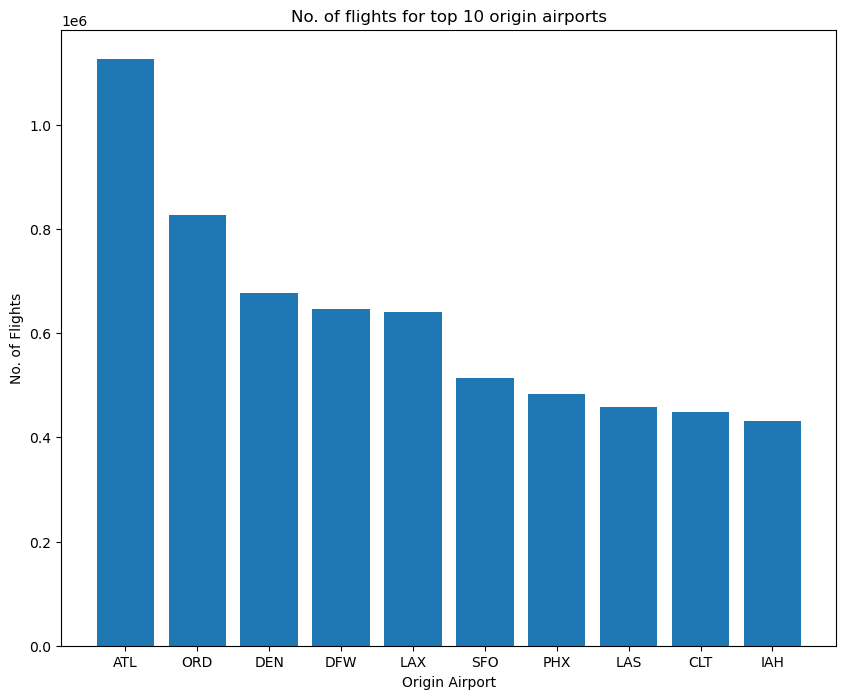

In [18]:
plt.figure(figsize=(10,8))
plt.bar(top_10_airports_pd["ORIGIN"], top_10_airports_pd["count"])
plt.xlabel("Origin Airport")
plt.ylabel("No. of Flights")
plt.title("No. of flights for top 10 origin airports")
plt.show()

#### 5.2 - Plot the longest flight by distance for the top 10 origin airports (3 points)

##### Tasks
1. Filter the original dataframe by top 10 origin airports
2. Calculate the longest flight by distance for each of the top 10 origin airports
3. Plot a bar plot of the longest flight by distance for the top 10 origin airports

Useful functions - [pyspark.sql.DataFrame.groupBy](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html), [pyspark.pandas.groupby.GroupBy.agg](https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/api/pyspark.pandas.groupby.DataFrameGroupBy.agg.html), [pyspark.sql.Column.alias](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.alias.html), [pyspark.sql.DataFrame.filter](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.filter.html), [pyspark.sql.Column.isin](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.isin.html), [matplotlib.pyplot.bar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html)

##### **Expected output** 

The longest flights by distance for the top 10 origin airports sorted in descending order of distance with column names 'ORIGIN' and 'MAX_DISTANCE'

In [ ]:
# Hint: Use the result of 5.1 and convert the top 10 airports Pyspark DF to a Pandas DF using toPandas() and then convert it into a 
# list to allow easy filtering. Make sure you only call toPandas() on the filtered Spark DF
from pyspark.sql.functions import max
from pyspark.sql.functions import col

top_10_airports_list = [row["ORIGIN"] for row in top_10_airports.collect()]

df_top_10_airports = df_transformed.filter(col("ORIGIN").isin(top_10_airports_list))

longest_flights = df_top_10_airports.groupBy("ORIGIN").agg(max(col("DISTANCE")).alias("MAX_DISTANCE")).orderBy(col("MAX_DISTANCE"), ascending=False)

##### **Expected output** A bar plot of the longest flight by distance for the top 10 origin airports titled 'Longest flight by distance for top 10 origin airports' with x-axis label as 'Origin Airport' and y-axis label as 'Distance (miles)'

In [21]:
longest_flights_pd = longest_flights.toPandas()

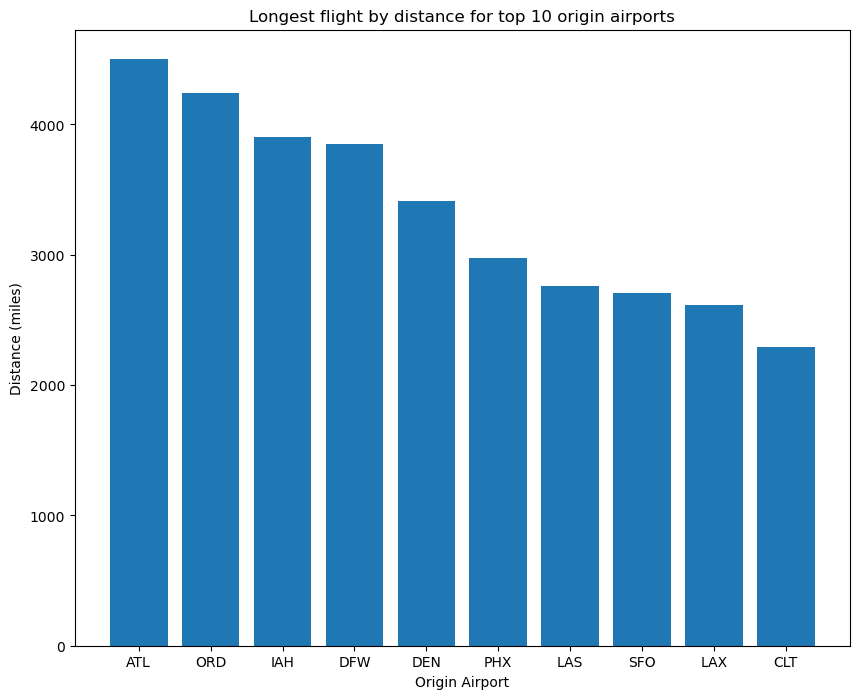

In [22]:
plt.figure(figsize=(10, 8))
plt.bar(longest_flights_pd["ORIGIN"], longest_flights_pd["MAX_DISTANCE"])
plt.xlabel("Origin Airport")
plt.ylabel("Distance (miles)")
plt.title("Longest flight by distance for top 10 origin airports")
plt.show()

### 6. Get a list of the 10 smallest flight carriers in the US - 2 points

##### Tasks
1. Count the number of flights for each flight carrier and sort in ascending order by count
2. Get the 10 smallest carriers from this sorted dataframe
3. Plot a pie chart of the flight counts of the smallest 10 carriers

Useful functions - [pyspark.sql.DataFrame.groupBy](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.groupBy.html), [pyspark.pandas.groupby.GroupBy.count](https://spark.apache.org/docs/latest/api/python/reference/pyspark.pandas/api/pyspark.pandas.groupby.GroupBy.count.html), [matplotlib.pyplot.pie](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pie.html)

##### **Expected output** The smallest 10 flight carriers and the count of flights from them under column names 'OP_CARRIER' and 'count'


In [ ]:
smallest_10_carriers = df_transformed.groupBy("OP_CARRIER").count().orderBy("count", ascending=True).limit(10)
smallest_10_carriers.show()

+----------+------+
|OP_CARRIER| count|
+----------+------+
|        G4| 95192|
|        VX|155092|
|        YV|209094|
|        9E|236403|
|        HA|239823|
|        OH|265784|
|        MQ|284497|
|        YX|305252|
|        F9|313232|
|        NK|460968|
+----------+------+



##### **Expected output** A pie chart of the flight share of the smallest 10 carriers titled 'Flight share of the smallest 10 Flight Carriers in the US'

In [39]:
smallest_10_carriers_pd = smallest_10_carriers.toPandas()

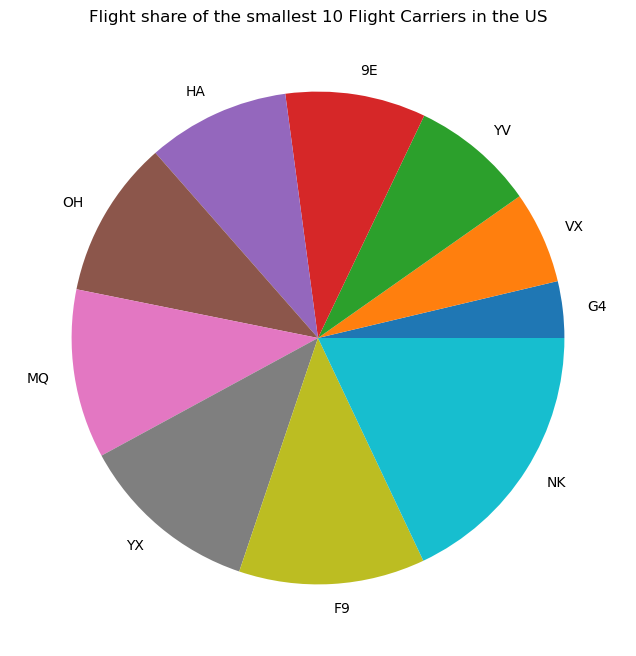

In [43]:
plt.figure(figsize=(10, 8))
plt.pie(
    smallest_10_carriers_pd["count"], 
    labels=smallest_10_carriers_pd["OP_CARRIER"]
)
plt.title("Flight share of the smallest 10 Flight Carriers in the US")
plt.show()

The codes of the flight carriers in your analysis above correspond to:

- 9E - Endeavor Air
- F9 - Frontier Airlines
- G4 - Allegiant Air
- HA - Hawaiian Airlines
- MQ - Envoy Air
- NK - Spirit Airlines
- OH - Jetstream Intl
- VX - Virgin America (Defunct)
- YV - Mesa Airlines
- YX - Republic Airlines

Source - [ASQP: Carrier Codes and Names](https://aspm.faa.gov/aspmhelp/index/ASQP__Carrier_Codes_and_Names.html)


### 7. Get the count of flights delayed by more than 30 minutes by the Smallest 10 carriers - 8 points

#### 7.1 - Filter the dataframe by the smallest 10 carriers (2 points)

Useful functions - [pyspark.sql.DataFrame.filter](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.filter.html), [pyspark.sql.Column.isin](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.Column.isin.html)

##### **Expected output** -  The top 25 rows of the filtered dataframe i.e. the dataframe containing only the Smallest 10 carriers in the 'OP_CARRIER' column

<!-- Your output should look like this: -->
<!-- 
|   FL_DATE|ORIGIN|ARR_DELAY|DAY_OF_WEEK|MONTH|
| ---------|------|---------|-----------|-----|
|2016-01-01|   ATL|     -2.0|          6|    1|
|2016-01-01|   LAX|    -13.0|          6|    1|
..23 more -->

In [ ]:
from pyspark.sql.functions import col

smallest_10_carriers_list = [row["OP_CARRIER"] for row in smallest_10_carriers.collect()]

df_filtered_smallest_carriers = df_transformed.filter(col("OP_CARRIER").isin(smallest_10_carriers_list))

df_filtered_smallest_carriers.show(25)

+----------+----------+------+--------+---------+-----------+-----+
|   FL_DATE|OP_CARRIER|ORIGIN|DISTANCE|ARR_DELAY|DAY_OF_WEEK|MONTH|
+----------+----------+------+--------+---------+-----------+-----+
|2016-01-01|        F9|   LAX|   862.0|     -4.0|          6|    1|
|2016-01-01|        F9|   DEN|  1607.0|    -11.0|          6|    1|
|2016-01-01|        F9|   ATL|   404.0|     -9.0|          6|    1|
|2016-01-01|        F9|   MCO|   404.0|    -14.0|          6|    1|
|2016-01-01|        F9|   LAS|  1747.0|    -10.0|          6|    1|
|2016-01-01|        F9|   ATL|  1947.0|    -19.0|          6|    1|
|2016-01-01|        F9|   IND|   977.0|    -40.0|          6|    1|
|2016-01-01|        F9|   DEN|  1709.0|    -14.0|          6|    1|
|2016-01-01|        F9|   CVG|   757.0|     -8.0|          6|    1|
|2016-01-01|        F9|   MCO|   757.0|    -10.0|          6|    1|
|2016-01-01|        F9|   MCO|   829.0|    -16.0|          6|    1|
|2016-01-01|        F9|   STL|   869.0|     -4.0

#### 7.2 - Filter dataframe for 10 smallest airlines by flights delayed by more than 30 minutes (1 point)

Useful functions - [pyspark.sql.DataFrame.filter](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.filter.html), [pyspark.sql.functions.col](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.col.html)

##### **Expected output** - The dataframe of the 10 smallest carriers filtered by flights delayed by more than 30 minutes.

In [79]:
from pyspark.sql.functions import col

df_smallest_carriers_30 = df_filtered_smallest_carriers.filter(col("ARR_DELAY") > 30)
df_smallest_carriers_30.show()

+----------+----------+------+--------+---------+-----------+-----+
|   FL_DATE|OP_CARRIER|ORIGIN|DISTANCE|ARR_DELAY|DAY_OF_WEEK|MONTH|
+----------+----------+------+--------+---------+-----------+-----+
|2016-01-01|        F9|   DEN|   888.0|     54.0|          6|    1|
|2016-01-01|        F9|   ORD|  1744.0|     55.0|          6|    1|
|2016-01-01|        F9|   ORD|  1514.0|     34.0|          6|    1|
|2016-01-01|        F9|   DEN|   896.0|    190.0|          6|    1|
|2016-01-01|        F9|   CLE|  1201.0|     52.0|          6|    1|
|2016-01-01|        F9|   LAS|  1678.0|    179.0|          6|    1|
|2016-01-01|        F9|   MKE|  1524.0|    190.0|          6|    1|
|2016-01-01|        HA|   SFO|  2398.0|     94.0|          6|    1|
|2016-01-01|        NK|   DTW|   629.0|     40.0|          6|    1|
|2016-01-01|        NK|   ORD|  1440.0|     33.0|          6|    1|
|2016-01-01|        NK|   LBE|   866.0|     42.0|          6|    1|
|2016-01-01|        NK|   MSP|  1299.0|     83.0

#### 7.3 - Calculate count of flights delayed by more than 30 minutes for the 10 smallest airlines (2 points)

##### **Expected output** - The smallest 10 carriers and the count of flights from them that are delayed by more than 30 minutes under column names 'OP_CARRIER', 'count'. Sort your results by 'count' in descending order.

In [80]:
df_smallest_carriers_30_10 = df_smallest_carriers_30.groupBy("OP_CARRIER").count().orderBy("count", ascending=False)
df_smallest_carriers_30_10.show()

+----------+-----+
|OP_CARRIER|count|
+----------+-----+
|        NK|61757|
|        F9|50771|
|        YX|36261|
|        MQ|35296|
|        OH|35249|
|        9E|29957|
|        YV|27634|
|        VX|24355|
|        G4|13562|
|        HA| 9532|
+----------+-----+



#### 7.4 - Plot count of flights delayed by more than 30 minutes for the Smallest 10 carriers (2 points)

Useful functions - [matplotlib.pyplot.bar](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.bar.html)

##### **Expected output** A bar plot of counts of flights delayed by more than 30 minutes for each of the Smallest 10 carriers titled 'No. of flights delayed more than 30 mins. for the smallest 10 carriers' with x-axis labelled as 'Carrier' and y-axis labelled as 'No. of flights'

In [81]:
df_smallest_carriers_30_10_pd = df_smallest_carriers_30_10.toPandas()

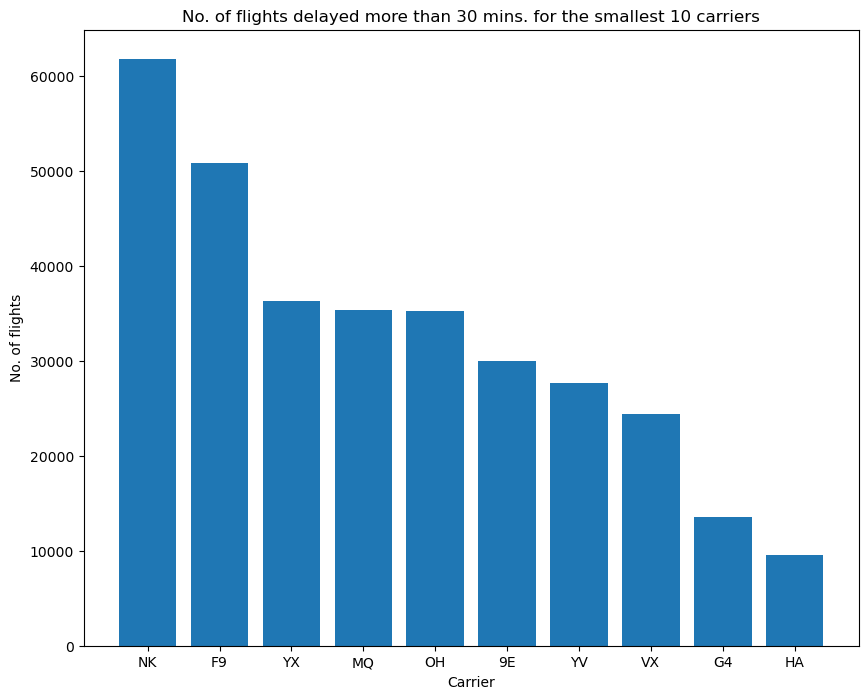

In [82]:
plt.figure(figsize=(10, 8))
plt.bar(df_smallest_carriers_30_10_pd["OP_CARRIER"], df_smallest_carriers_30_10_pd["count"])
plt.xlabel("Carrier")
plt.ylabel("No. of flights")
plt.title("No. of flights delayed more than 30 mins. for the smallest 10 carriers")
plt.show()

#### 7.5 - Filter to get data for the smallest carrier and save the filtered DataFrame as a CSV File on the local filesystem ( 1 point)

**NOTE**: Spark uses a distributed memory system, and stores working data in fragments known as "partitions". This is advantageous when a Spark cluster spans multiple machines, as each machine will only require part of the working data to do its own job. By default, Spark will save each of these data partitions into a individual file to avoid I/O collisions. We want only one output file, so we'll need to fuse all the data into a single partition first. 

Your task: 
1. Filter the dataframe from **step 7.1** to contain only rows with flights from the **SMALLEST** carrier as observed in the pie chart from **step 6**.
2. Coalesce this filtered dataframe you just created to one partition using `DataFrame.coalesce(1)`. This returns a 1-partition dataframe. This makes sure that all our results will end up in the same csv file. 
3. Save the 1-partition dataframe to your local filesystem using the `DataFrame.write.csv(<path>)` method. Remember that you need "file://\<path\>/\<filename\>" when writing to the local file system.
4. In your local filesystem, you should see a folder with the specified \<filename\>. Since we made sure to coalesce our dataframe to just one partition, we should expect to find only one saved partition in this folder, saved also as a CSV. Note the name of this file, it should look something like `part-00000-xx.....xx.csv`. You may rename this file to something more interpretable - let's say `results.csv`. 
5. Finally, we want you to submit a CSV containing the first 50 rows of the results file. Remember that we want the first 51 lines which would include the header as well - so basically it is header + 50 rows.

**REMINDER**: The results are saved to your local filesystem and the folder where you executed your launch script is mapped to the '/home/work' directory in your Docker container. You can read more about this mapping here - https://docs.docker.com/engine/storage/bind-mounts/

##### **Expected output**: None

In [88]:
from pyspark.sql.functions import col

# Get the smallest carrier (first row of smallest_10_carriers)
smallest_carrier = smallest_10_carriers.limit(1)

smallest_carrier.show()

+----------+-----+
|OP_CARRIER|count|
+----------+-----+
|        G4|95192|
+----------+-----+



In [90]:
smallest_carriers_list = [row["OP_CARRIER"] for row in smallest_carrier.collect()]

df_smallest_carriers_top_50 = df_transformed.filter(col("OP_CARRIER").isin(smallest_carriers_list)).limit(50)

df_smallest_carriers_top_50.show()

+----------+----------+------+--------+---------+-----------+-----+
|   FL_DATE|OP_CARRIER|ORIGIN|DISTANCE|ARR_DELAY|DAY_OF_WEEK|MONTH|
+----------+----------+------+--------+---------+-----------+-----+
|2018-01-01|        G4|   FLL|   851.0|     15.0|          2|    1|
|2018-01-01|        G4|   MEM|   851.0|      5.0|          2|    1|
|2018-01-01|        G4|   FLL|   620.0|     30.0|          2|    1|
|2018-01-01|        G4|   GSP|   620.0|     37.0|          2|    1|
|2018-01-01|        G4|   FLL|   781.0|     68.0|          2|    1|
|2018-01-01|        G4|   ORF|   781.0|     63.0|          2|    1|
|2018-01-01|        G4|   SFB|   511.0|     14.0|          2|    1|
|2018-01-01|        G4|   TYS|   511.0|      6.0|          2|    1|
|2018-01-01|        G4|   PIE|   831.0|      2.0|          2|    1|
|2018-01-01|        G4|   DAY|   831.0|      6.0|          2|    1|
|2018-01-01|        G4|   PIE|  1126.0|     -6.0|          2|    1|
|2018-01-01|        G4|   DSM|  1126.0|     -6.0

In [91]:
df_single_partition = df_smallest_carriers_top_50.coalesce(1)

df_single_partition.write.mode("overwrite").csv("hdfs:///Demo1-HDFS/50_rows.csv", header=True)

The resultant file saved in the step above is actually a folder, which contains individually saved files from each partition of the saved dataframe. <br> <br>
Now, use a command to show the contents of the resulting folder on your local filesystem from the last step in the cell below. <br>
You will need to include ‘!’ before the command for Jupyter Notebook to recognize it as an operating system command. For instance '! pwd' displays the path name of your current directory.

In [92]:
! pwd

/home/jovyan/MGTA466:Session1/Demo1-Local


#### **Expected output**: List of files in the directory where results were written out by PySpark. You should see a '_SUCCESS' file in this directory

In [93]:
! hdfs dfs -ls hdfs:///Demo1-HDFS/50_rows.csv

Found 2 items
-rw-r--r--   1 jovyan supergroup          0 2025-03-01 17:55 hdfs:///Demo1-HDFS/50_rows.csv/_SUCCESS
-rw-r--r--   1 jovyan supergroup       1729 2025-03-01 17:55 hdfs:///Demo1-HDFS/50_rows.csv/part-00000-b8da10b3-dec2-4dbd-9866-565e210b7f12-c000.csv


Now, stop the spark session in the cell below
#### **Expected output**: None

In [94]:
! hdfs dfs -ls /

Found 1 items
drwxr-xr-x   - jovyan supergroup          0 2025-03-01 17:55 /Demo1-HDFS


In [95]:
! hdfs dfs -get hdfs:///Demo1-HDFS/50_rows.csv/part-00000-b8da10b3-dec2-4dbd-9866-565e210b7f12-c000.csv 50_rows.csv

In [96]:
# Stop Spark session

spark.stop()

In [97]:
#Stop HDFS
!$HADOOP_HOME/stop-dfs.sh

Stopping HDFS ...


### 8. Submission of `50_rows.csv` - 2 points

#### **Expected output**(in the 50_rows.csv file) - Top 50 rows of the Dataframe filtered by the smallest flight carrier + column header
**NOTE** - No output is expected in the notebook

The csv file should have seven columns, `FL_DATE`, `OP_CARRIER`, `ORIGIN`, `DISTANCE`, `ARR_DELAY`, `DAY_OF_WEEK`, `MONTH`, in the first line and 50 more lines with the top 50 rows of the filtered dataframe.